#IMPORTS

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download lngcthun/utkface-convert-csv
! unzip /content/utkface-convert-csv.zip

 95% 192M/203M [00:01<00:00, 177MB/s]
100% 203M/203M [00:01<00:00, 132MB/s]
Archive:  /content/utkface-convert-csv.zip
  inflating: utkface_sortAge.csv     


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import torch
df = pd.read_csv("/content/utkface_sortAge.csv")


In [ ]:
df.head()

,Unnamed: 0,age,gender,ethnicity,image
0,2226,1,1,0,109 146 198 132 169 221 134 171 223 137 174 22...
1,2047,1,0,3,0 1 2 2 1 1 5 1 0 11 3 3 1 0 6 27 35 45 97 111...
2,2048,1,0,3,54 64 91 55 66 95 56 72 105 58 76 113 67 85 12...
3,2049,1,0,3,80 98 125 77 94 129 113 131 169 147 169 201 16...
4,2050,1,0,3,63 55 96 58 51 94 72 67 112 83 80 126 91 90 13...


In [ ]:
df['image'][0]

'109 146 198 132 169 221 134 171 223 137 174 226 138 172 231 138 172 231 139 173 232 141 175 234 138 178 236 141 179 237 146 181 240 147 181 240 150 181 242 151 183 242 152 185 241 149 183 237 143 177 236 143 177 236 144 178 239 135 168 231 126 158 223 123 155 220 119 151 216 113 145 210 118 150 215 126 159 222 127 161 221 126 160 219 118 155 211 121 158 216 118 154 214 107 142 205 86 125 187 73 111 175 71 109 174 71 108 176 63 89 156 64 92 158 85 117 180 73 107 167 83 120 176 97 134 190 100 137 195 100 136 195 100 145 195 112 155 203 123 165 211 122 163 207 128 174 217 154 197 229 107 144 196 128 165 217 136 173 225 138 175 227 136 170 229 136 170 229 138 172 231 139 173 232 137 177 235 140 178 236 144 180 238 145 179 238 147 178 239 148 180 239 149 182 238 146 180 234 143 178 234 143 177 236 140 174 234 134 167 229 129 161 225 126 159 223 123 156 220 114 147 211 118 150 215 126 159 222 126 160 220 130 164 223 123 160 216 123 160 218 117 153 213 111 146 209 98 134 198 72 107 173 84 11

#Data Preprocessing for VAE without Dense Block

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define a PyTorch transformation to convert PIL image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

image_tensor = []
for image_str in df['image']:
    pixel_array = np.array(image_str.split(), dtype=np.uint8)

    # Reshape pixel array to match the image dimensions
    image_size = int(np.sqrt(len(pixel_array) / 3))
    pixel_array = pixel_array.reshape((image_size, image_size, 3))
    pil_image = Image.fromarray(pixel_array)
    tensor_image = transform(pil_image)
    image_tensor.append(tensor_image)

# Convert list of tensors to a single tensor
image_tensor = torch.stack(image_tensor)
image_tensor = F.interpolate(image_tensor, size=(48, 48), mode='bilinear', align_corners=False)

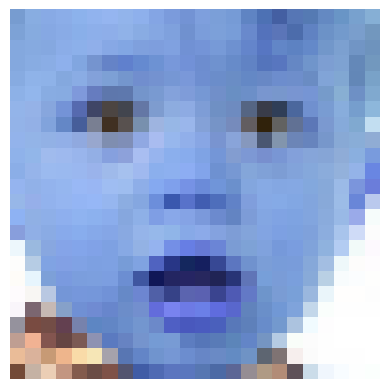

In [ ]:
plt.imshow(image_tensor[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
import torch
image_tensor = torch.sigmoid(image_tensor)

In [ ]:
gender_tensor = torch.tensor(df['gender'].values, dtype=torch.float32)
labels_tensor = gender_tensor

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

total_samples = len(image_tensor)
train_samples = int(0.7 * total_samples)
val_samples = int(0.15 * total_samples)
test_samples = total_samples - train_samples - val_samples

train_data = image_tensor[:train_samples]
train_labels = labels_tensor[:train_samples]

val_data = image_tensor[train_samples:train_samples+val_samples]
val_labels = labels_tensor[train_samples:train_samples+val_samples]

test_data = image_tensor[train_samples+val_samples:]
test_labels = labels_tensor[train_samples+val_samples:]

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# VAE Without Dense Block

In [ ]:
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, image_channels=3, latent_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
          nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
          nn.ReLU(),
          nn.Flatten()
        )


        self.fc_mu = nn.Linear(2304, 64)
        self.fc_logvar = nn.Linear(2304, 64)

        self.fc = nn.Linear(64, 256*3*3)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        x = self.fc(z)
        x = x.view(x.size(0), 256, 3, 3)

        x = self.decoder(x)
        return x, mu, logvar


Epoch [1/2], Train Loss: 4603.5598, Val Loss: 4605.7049
Epoch [2/2], Train Loss: 4588.2712, Val Loss: 4592.7264


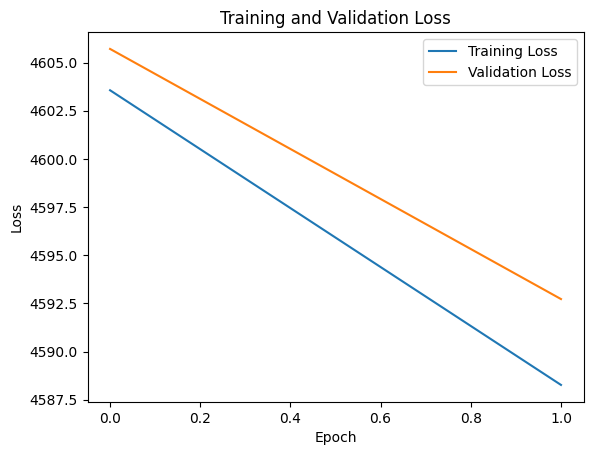

In [ ]:
model = VAE()

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        optimizer.zero_grad()

        data = data.float()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_dataloader):
            data = data.float()

            recon_batch, mu, logvar = model(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()

    val_loss /= len(val_dataloader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


#Data Preprocessing for VAE with Dense Block

In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.ToTensor(),
])

image_tensor = []
for image_str in df['image']:
    pixel_array = np.array(image_str.split(), dtype=np.uint8)

    image_size = int(np.sqrt(len(pixel_array) / 3))
    pixel_array = pixel_array.reshape((image_size, image_size, 3))

    pil_image = Image.fromarray(pixel_array)

    tensor_image = transform(pil_image)
    image_tensor.append(tensor_image)

image_tensor = torch.stack(image_tensor)
image_tensor = F.interpolate(image_tensor, size=(48, 48), mode='bilinear', align_corners=False)

In [ ]:
gender_tensor = torch.tensor(df['gender'].values, dtype=torch.float32)
labels_tensor = gender_tensor

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

total_samples = len(image_tensor)
train_samples = int(0.7 * total_samples)
val_samples = int(0.15 * total_samples)
test_samples = total_samples - train_samples - val_samples

train_data = image_tensor[:train_samples]
train_labels = labels_tensor[:train_samples]

val_data = image_tensor[train_samples:train_samples+val_samples]
val_labels = labels_tensor[train_samples:train_samples+val_samples]

test_data = image_tensor[train_samples+val_samples:]
test_labels = labels_tensor[train_samples+val_samples:]

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#VAE with Dense Block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, image_channels=3, latent_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            DenseBlock(nb_layers=2, in_planes=32, growth_rate=32, block=BasicBlock),
            nn.Conv2d(96, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            DenseBlock(nb_layers=2, in_planes=64, growth_rate=64, block=BasicBlock),
            nn.ConvTranspose2d(192, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )


        self.fc_mu = nn.Linear(9216, latent_dim)
        self.fc_logvar = nn.Linear(9216, latent_dim)
        self.fc = nn.Linear(latent_dim, 256*3*3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc(z)
        x = x.view(x.size(0), 256, 3, 3)
        x = self.decoder(x)
        return x, mu, logvar

#  BasicBlock class for the dense block
class BasicBlock(nn.Module):
    def __init__(self, in_planes, growth_rate, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_planes, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.dropRate = dropRate

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        if self.dropRate > 0:
            out = F.dropout(out, p=self.dropRate, training=self.training)
        return torch.cat([x, out], 1)

#  DenseBlock class
class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes + i * growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)


#Training and Plotting the loss vs epoch curve

In [ ]:
model = VAE()

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        optimizer.zero_grad()
        data = data.float()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_dataloader):
            data = data.float()

            recon_batch, mu, logvar = model(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()

    val_loss /= len(val_dataloader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


ValueError: Using a target size (torch.Size([64, 3, 48, 48])) that is different to the input size (torch.Size([64, 3, 24, 24])) is deprecated. Please ensure they have the same size.

#Reconstructing Test Dataset

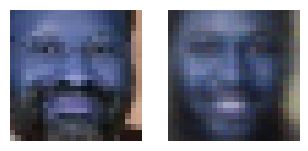

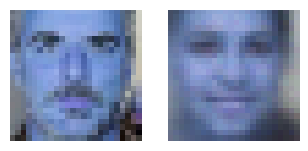

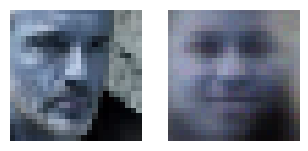

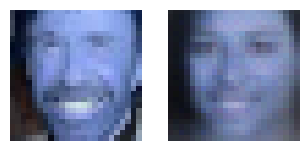

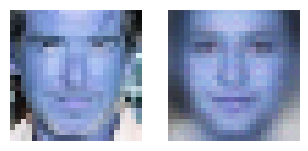

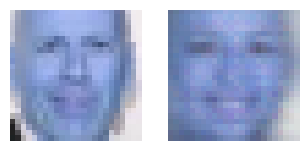

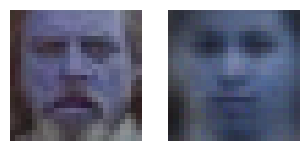

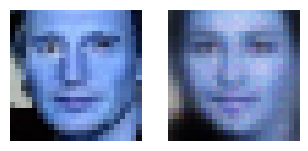

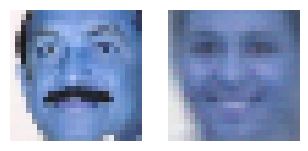

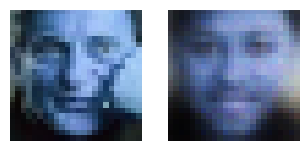

In [ ]:
import matplotlib.pyplot as plt

def plot_reconstructions(model, test_loader, num_images=5):
    model.eval()
    num_batches = len(test_loader)
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i * len(images) >= num_images:
                break
            images = images.to(device)
            recon_images, _, _ = model(images)
            for j in range(len(images)):
                if i * len(images) + j >= num_images:
                    break
                plt.figure(figsize=(20, 10))
                plt.subplot(2, num_images, 2 * j + 1)
                plt.imshow(images[j].cpu().permute(1, 2, 0))
                plt.axis('off')
                plt.subplot(2, num_images, 2 * j + 2)
                plt.imshow(recon_images[j].cpu().permute(1, 2, 0))
                plt.axis('off')
            plt.show()

plot_reconstructions(model, test_dataloader, num_images=10)


#Latent Space Visualization

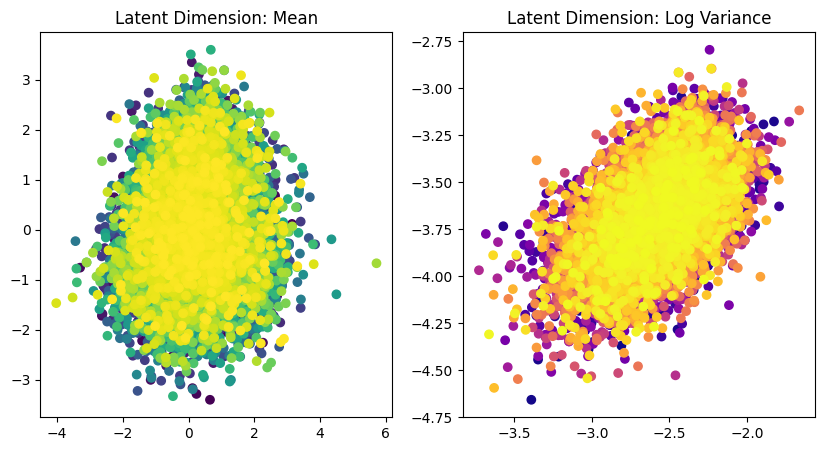

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def plot_latent_dimension(vae, data):
    vae.eval()
    with torch.no_grad():
        latent_mu = []
        latent_logvar = []
        for x, _ in data:
            x = x.to(device)
            _, mu, logvar = vae(x)
            latent_mu.append(mu)
            latent_logvar.append(logvar)

        latent_mu = torch.cat(latent_mu, dim=0).cpu().numpy()
        latent_logvar = torch.cat(latent_logvar, dim=0).cpu().numpy()

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(latent_mu[:, 0], latent_mu[:, 1], c=range(len(latent_mu)), cmap='viridis')  # Change cmap here
        plt.title('Latent Dimension: Mean')

        plt.subplot(1, 2, 2)
        plt.scatter(latent_logvar[:, 0], latent_logvar[:, 1], c=range(len(latent_logvar)), cmap='plasma')  # Change cmap here
        plt.title('Latent Dimension: Log Variance')

        plt.show()

plot_latent_dimension(model, train_dataloader)


#Regular Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Convolutional layer 1
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Convolutional layer 2
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Convolutional layer 3
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 1
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 2
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Transposed convolutional layer 3
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder()

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')


[1,   100] loss: 0.043
[1,   200] loss: 0.017
[2,   100] loss: 0.014
[2,   200] loss: 0.013
[3,   100] loss: 0.011
[3,   200] loss: 0.010
[4,   100] loss: 0.009
[4,   200] loss: 0.008
[5,   100] loss: 0.007
[5,   200] loss: 0.007
[6,   100] loss: 0.007
[6,   200] loss: 0.007
[7,   100] loss: 0.006
[7,   200] loss: 0.006
[8,   100] loss: 0.006
[8,   200] loss: 0.006
[9,   100] loss: 0.006
[9,   200] loss: 0.006
[10,   100] loss: 0.005
[10,   200] loss: 0.005
Finished Training


[1,   100] loss: 0.005


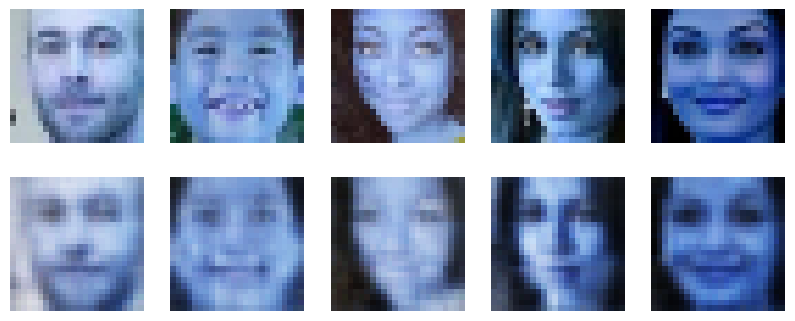

[1,   200] loss: 0.005


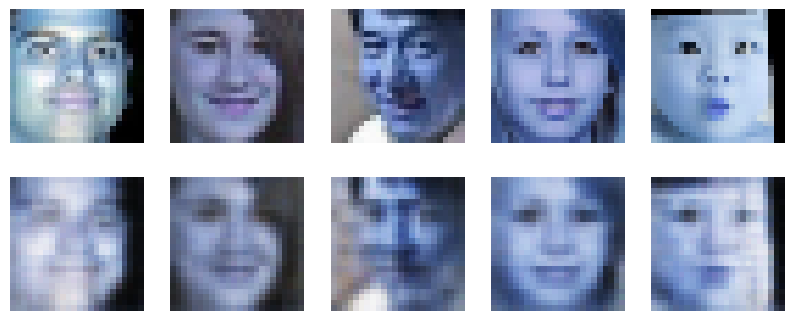

[2,   100] loss: 0.005


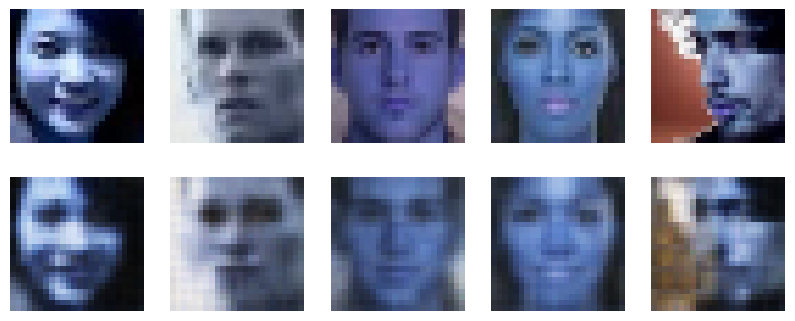

[2,   200] loss: 0.005


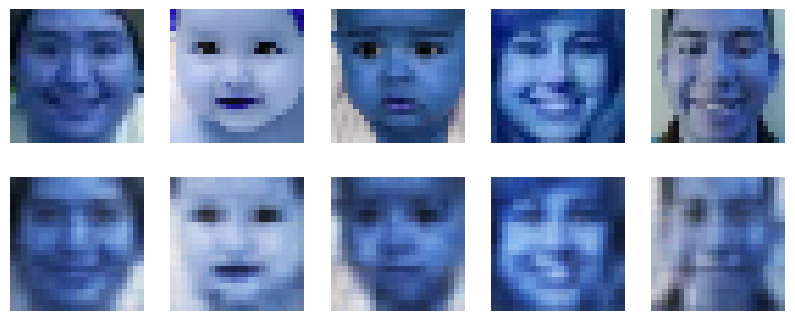

[3,   100] loss: 0.005


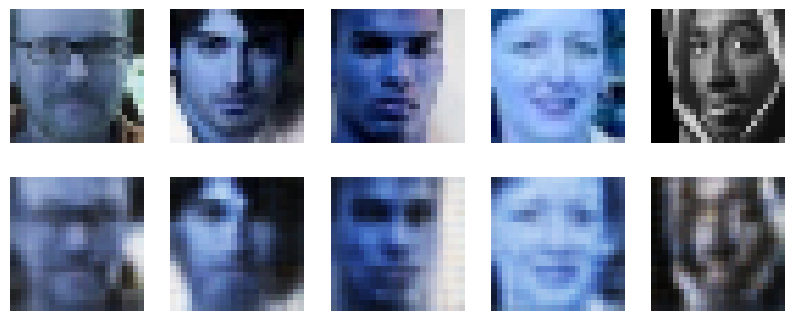

[3,   200] loss: 0.005


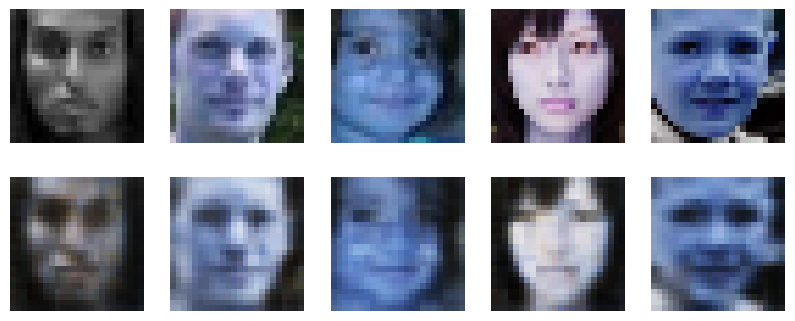

[4,   100] loss: 0.005


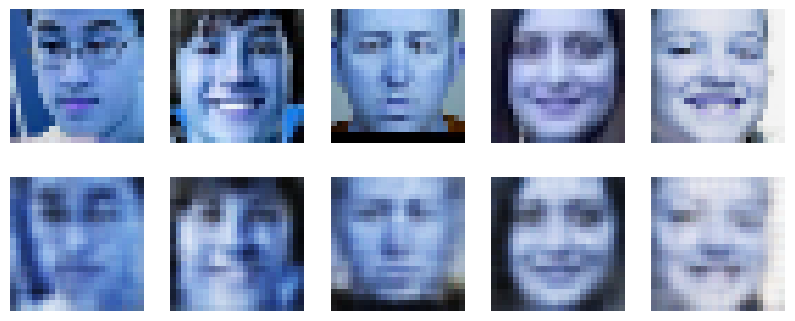

[4,   200] loss: 0.005


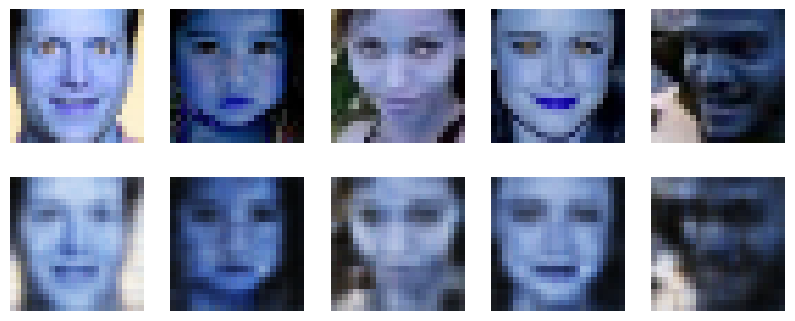

[5,   100] loss: 0.005


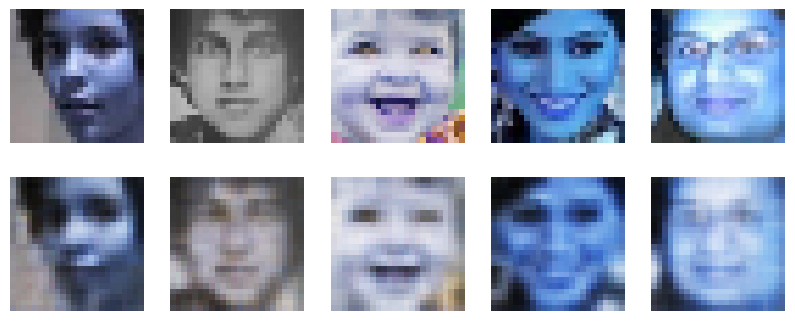

[5,   200] loss: 0.005


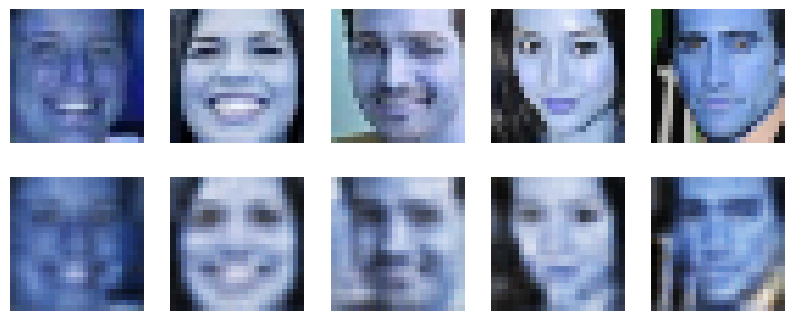

[6,   100] loss: 0.005


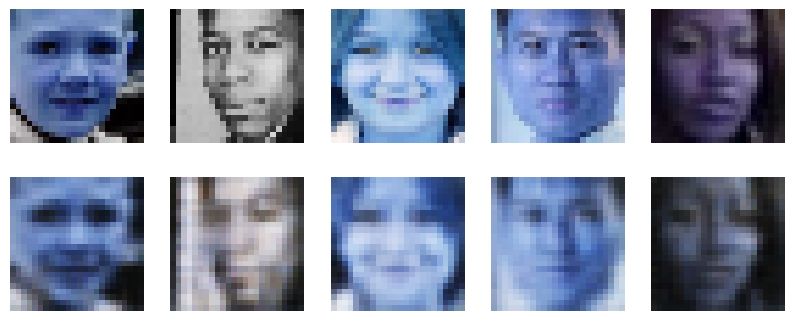

[6,   200] loss: 0.005


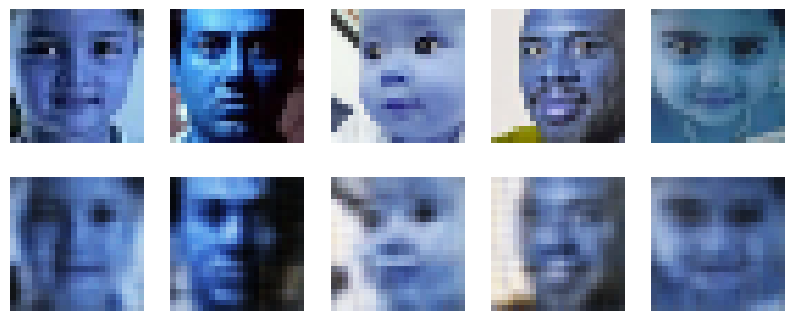

[7,   100] loss: 0.004


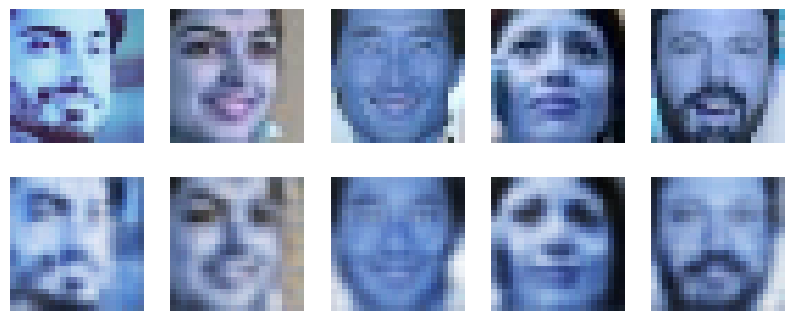

[7,   200] loss: 0.004


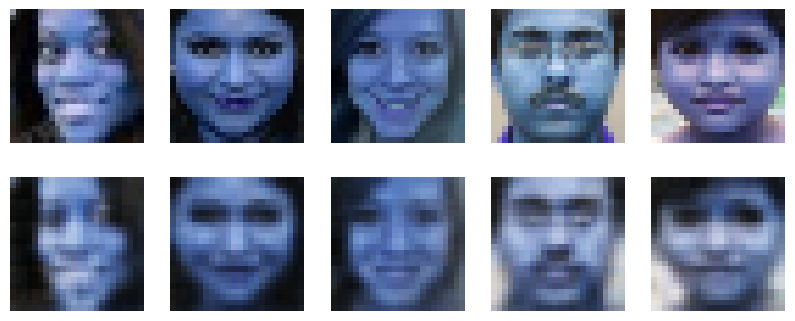

[8,   100] loss: 0.004


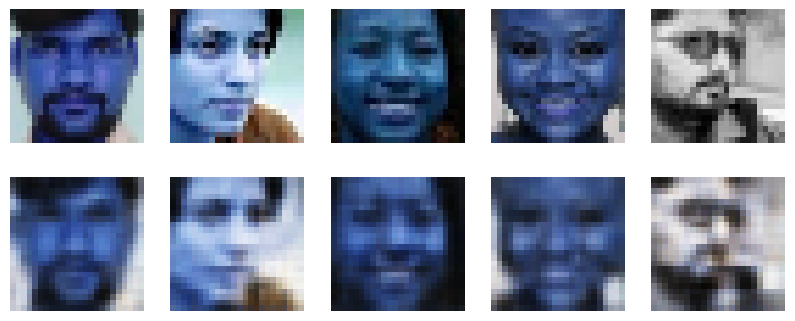

[8,   200] loss: 0.004


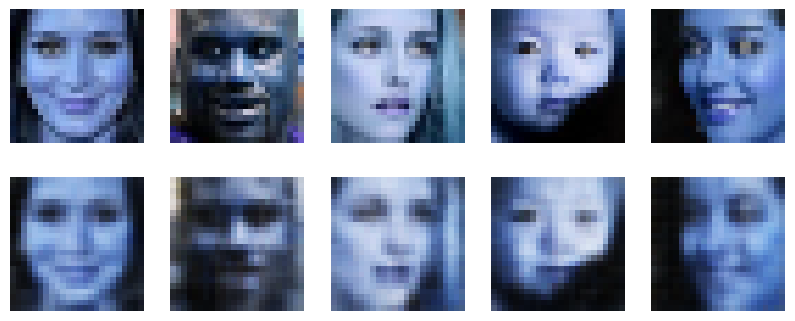

[9,   100] loss: 0.004


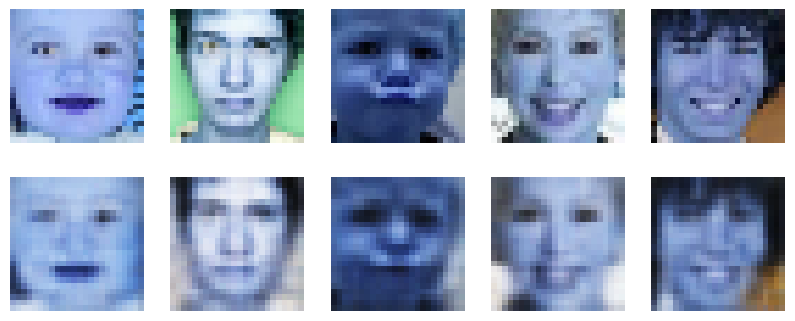

[9,   200] loss: 0.004


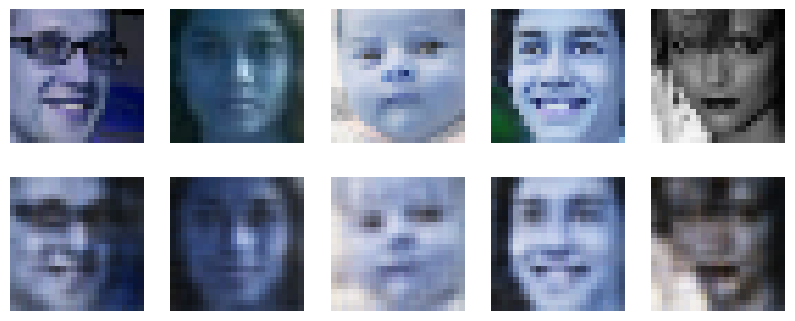

[10,   100] loss: 0.004


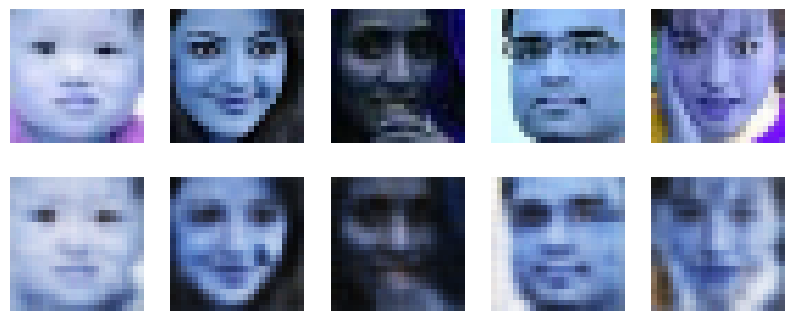

[10,   200] loss: 0.004


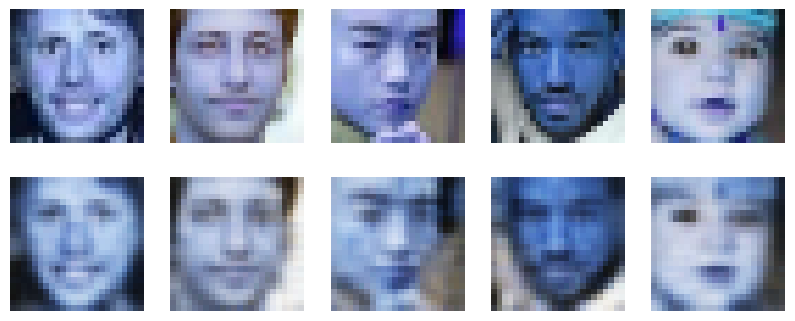

Finished Training


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(original, reconstructed, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[1, i].imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        axes[1, i].axis('off')
    plt.show()

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, _ = data
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            plot_images(inputs[:5], outputs[:5].detach().numpy())

print('Finished Training')


#Randomly sample a point from the latent space of the VAE and compare the output from the decoder with that of a regular autoencoder

In [ ]:
import torch

def sample_from_latent_space(vae):
    latent_dim = vae.fc_mu.out_features
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated_image = vae.decoder(vae.fc(z).view(1, -1, 3, 3))
    return generated_image

generated_image = sample_from_latent_space(model)

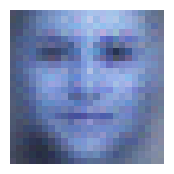

In [ ]:
import matplotlib.pyplot as plt

def sample_from_latent_space(vae):
    latent_dim = vae.fc_mu.out_features
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated_image = vae.decoder(vae.fc(z).view(1, -1, 3, 3))
    return generated_image

generated_image = sample_from_latent_space(model)
plt.figure(figsize=(2, 2))
plt.imshow(generated_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

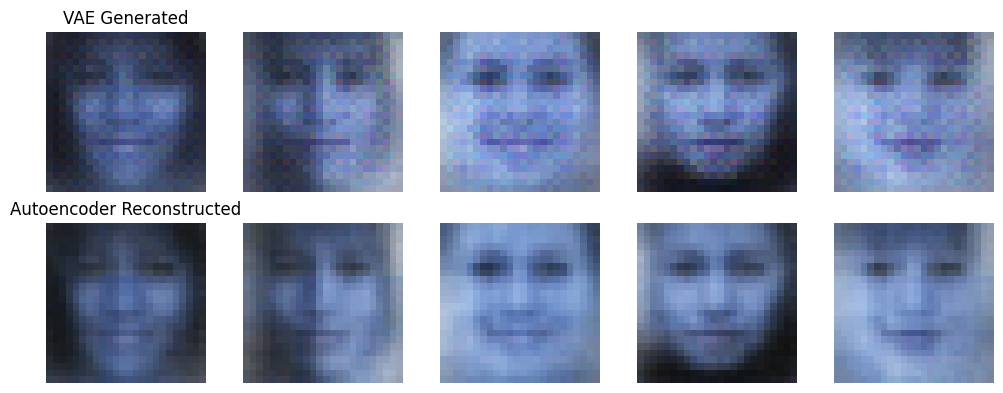

In [ ]:
import torch
import matplotlib.pyplot as plt


def sample_and_test_autoencoder(vae, autoencoder, device, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        with torch.no_grad():
            latent_dim = vae.fc_mu.out_features
            z_vae = torch.randn(1, latent_dim).to(device)
            generated_image = vae.decoder(vae.fc(z_vae).view(-1, 256, 3, 3))

        with torch.no_grad():
          latent_mu = vae.fc_mu(torch.randn(1, vae.fc_mu.in_features).to(device))
          latent_dim_autoencoder = autoencoder.decoder[0].in_channels
          latent_autoencoder = latent_mu.view(1, latent_dim_autoencoder, 1, 1)
          reconstructed_image = autoencoder.decoder(latent_autoencoder)
        axes[0, i].imshow(generated_image.squeeze().permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_image.squeeze().permute(1, 2, 0).cpu().numpy())
        axes[1, i].axis('off')

    axes[0, 0].set_title('VAE Generated')
    axes[1, 0].set_title('Autoencoder Reconstructed')

    plt.tight_layout()
    plt.show()

sample_and_test_autoencoder(model, autoencoder, device, num_images=5)


#t-SNE

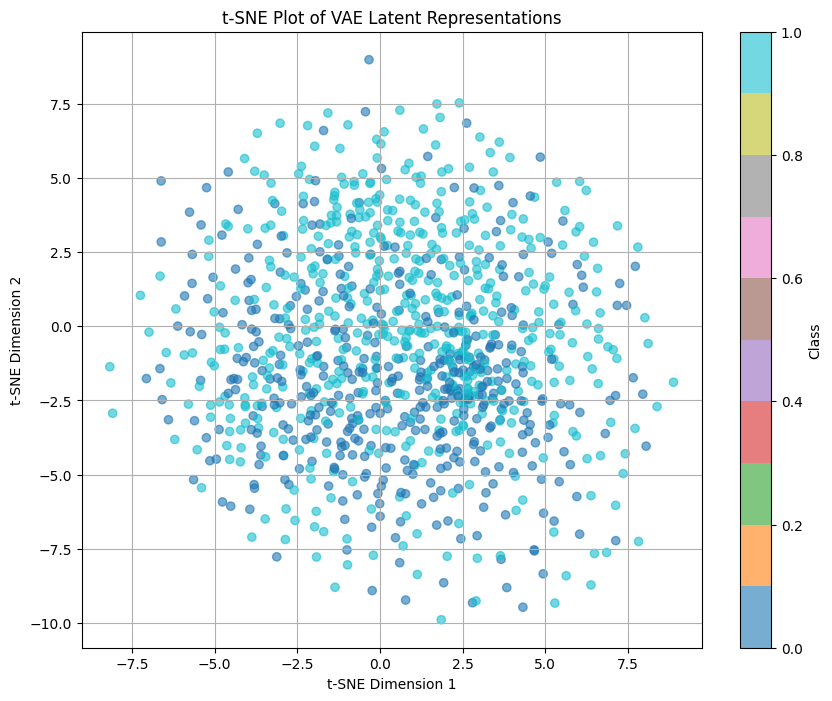

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def plot_tsne(vae, data_loader, max_samples=1000):
    vae.eval()
    with torch.no_grad():
        latent_representations = []
        labels = []
        total_samples = 0
        for x, y in data_loader:
            x = x.to(device)
            _, mu, _ = vae(x)
            latent_representations.append(mu)
            labels.append(y)
            total_samples += x.size(0)
            if total_samples >= max_samples:
                break

        latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()
        labels = torch.cat(labels, dim=0).cpu().numpy()

    num_samples = min(max_samples, total_samples)

    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_representations[:num_samples])

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels[:num_samples], cmap='tab10', alpha=0.6)
    plt.title('t-SNE Plot of VAE Latent Representations')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(label='Class')
    plt.grid(True)
    plt.show()

plot_tsne(model, train_dataloader, max_samples=1000)


#Evaluate the performance based of ELBO score

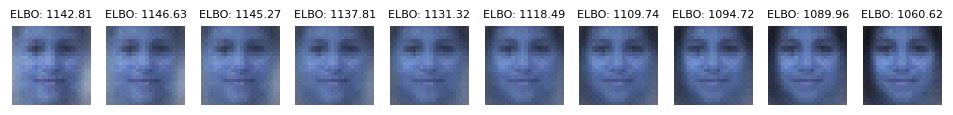

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def interpolate_latent_space(vae, z1, z2, num_steps=10):
    interpolated_z = []
    for alpha in torch.linspace(0, 1, num_steps):
        z_interpolated = alpha * z1 + (1 - alpha) * z2
        interpolated_z.append(z_interpolated)
    with torch.no_grad():
        generated_images = []
        for z in interpolated_z:
            generated_image = vae.decoder(vae.fc(z).view(1, -1, 3, 3))
            generated_images.append(generated_image.squeeze().permute(1, 2, 0).cpu().numpy())

    return generated_images

def compute_elbo(vae, images):
    with torch.no_grad():
        recon_images, mu, logvar = vae(images)
        recon_loss = F.binary_cross_entropy(recon_images, images, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        elbo = recon_loss + kl_divergence
    return elbo.item()

def plot_interpolated_images_and_scores(interpolated_images, elbo_scores):
    plt.figure(figsize=(12, 6))
    for i, (image, score) in enumerate(zip(interpolated_images, elbo_scores)):
        plt.subplot(1, len(interpolated_images), i + 1)
        plt.imshow(image)
        plt.title(f'ELBO: {score:.2f}', fontsize=8)
        plt.axis('off')
    plt.show()

latent_dim = model.fc_mu.out_features
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)

interpolated_images = interpolate_latent_space(model, z1, z2)

elbo_scores = []
for image in interpolated_images:
    image_tensor = torch.tensor(image, dtype=torch.float).permute(2, 0, 1).unsqueeze(0).to(device)
    score = compute_elbo(model, image_tensor)
    elbo_scores.append(score)

# Plot interpolated images and their ELBO scores
plot_interpolated_images_and_scores(interpolated_images, elbo_scores)


#Take the latent representation of VAE and evaluate its performance on a classification task

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def get_latent_and_labels(vae, data_loader, max_samples=1000):
    vae.eval()
    with torch.no_grad():
        latent_representations = []
        labels = []
        total_samples = 0
        for x, y in data_loader:
            x = x.to(device)
            _, mu, _ = vae(x)
            latent_representations.append(mu)
            labels.append(y)
            total_samples += x.size(0)
            if total_samples >= max_samples:
                break

        latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()
        labels = torch.cat(labels, dim=0).cpu().numpy()

    num_samples = min(max_samples, total_samples)

    return latent_representations[:num_samples], labels[:num_samples]
latent_representations, labels = get_latent_and_labels(model, train_dataloader, max_samples=1000)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

latent_representations_flat = latent_representations.reshape(latent_representations.shape[0], -1)
labels_tensor = torch.from_numpy(labels)

X_train, X_test, y_train, y_test = train_test_split(latent_representations_flat, labels_tensor, test_size=0.2, random_state=42)

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = latent_representations_flat.shape[1]
num_classes = len(torch.unique(labels_tensor))
classifier = Classifier(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for inputs, targets in zip(X_train, y_train):
        inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)
        inputs = inputs.unsqueeze(0)
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, targets.unsqueeze(0))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(X_train)}")

classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in zip(X_test, y_test):
        inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)
        inputs = inputs.unsqueeze(0)
        outputs = classifier(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == targets).sum().item()

print(f"Accuracy on Testing Set: {(correct / total) * 100:.2f}%")


<ipython-input-106-355b8137a95f>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)


Epoch [1/10], Loss: 0.6372308390261605
Epoch [2/10], Loss: 0.6047825532057323
Epoch [3/10], Loss: 0.5890400620270521
Epoch [4/10], Loss: 0.5766042052203556
Epoch [5/10], Loss: 0.5655167332995916
Epoch [6/10], Loss: 0.554676867724047
Epoch [7/10], Loss: 0.5433871606804314
Epoch [8/10], Loss: 0.5336239528725855
Epoch [9/10], Loss: 0.5232734254162642
Epoch [10/10], Loss: 0.512747921996488
Accuracy on Testing Set: 73.00%


<ipython-input-106-355b8137a95f>:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, targets = torch.tensor(inputs, dtype=torch.float32).to(device), torch.tensor(targets, dtype=torch.long).to(device)


#Discuss how you can improve the VAE's ability to generate high fidelity and diverse samples

We can do this by 2 ways:

Deep Feature Consistency:  Deep feature consistency ensures that the "deep features" extracted from both the original and generated images are similar. By deep feature consistency we can make sure that the VAE doesn't just produce any random image, but rather generates images that are meaningful and faithful to the input. This helps maintain the quality and fidelity of the generated images, making them more useful for tasks like image generation and reconstruction.

Generative Adversarial Training: With generative adversarial training, we introduce another artist called the "discriminator." The discriminator's job is to critique the VAE's paintings and tell it where it's going wrong. We try to make VAE to improve its paintings to fool the discriminator into thinking they're real. This competition between the VAE and the discriminator pushes the VAE to create images with clearer details, more natural textures, and backgrounds that make sense. Overall, it helps the VAE become better at generating images that look like they could be real photographs.

By combining these techniques, the method achieves superior performance in generating high-quality images.